### Calibrate single image

In [404]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from skimage import data, io
from skimage.filters import try_all_threshold
from skimage.filters import threshold_otsu
from skimage.draw import ellipse
from skimage.measure import label, regionprops
from skimage.transform import rotate
import re
import imageio

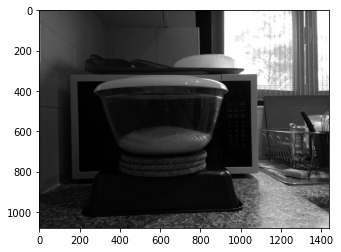

In [405]:
def read_photo(photo_path):
    photo = io.imread(fname=photo_path, as_gray=True)
    return photo

photo_path = "../data/dough-photos/1/2021-03-23_12-14-02_(0).jpg"
photo = read_photo(photo_path)
plt.imshow(photo, cmap='gray')

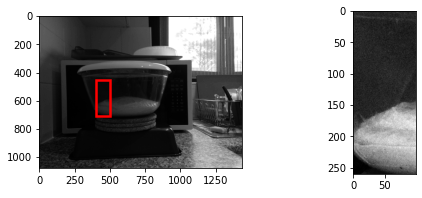

In [406]:
crop_x = (450,710)
crop_y = (400,500)

def crop_photo(photo, crop_x, crop_y):
    return photo[crop_x[0]:crop_x[1], crop_y[0]:crop_y[1]]


fid, axes = plt.subplots(ncols=2, figsize=(8,3))
ax = axes.ravel()

ax[0].imshow(photo, cmap='gray')
rect = patches.Rectangle((crop_y[0], crop_x[0]), crop_y[1] - crop_y[0], crop_x[1] - crop_x[0], linewidth=2.5, edgecolor='r', facecolor='none')
ax[0].add_patch(rect)

img = crop_photo(photo, crop_x, crop_y)
ax[1].imshow(img, cmap='gray')
plt.show()

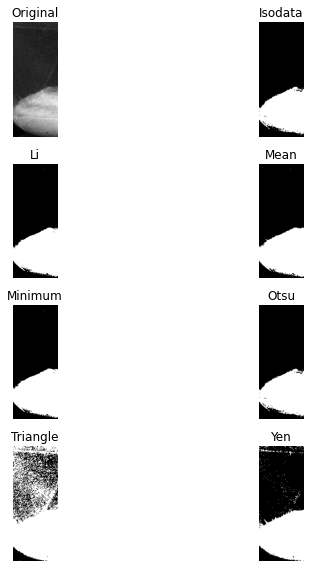

In [407]:
fig, ax = try_all_threshold(img, figsize=(10,8), verbose=False)
plt.show()

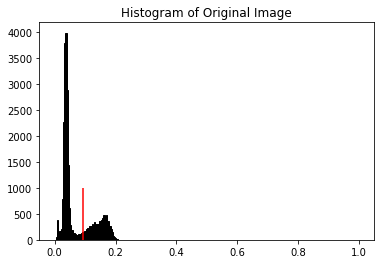

In [408]:

def find_threshold(img):
    return threshold_otsu(img, nbins=256)

otsu_thresh = find_threshold(img)
plt.hist(img.ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k')
plt.vlines(otsu_thresh, 0, 1000, 'r')
plt.title('Histogram of Original Image')
plt.show()

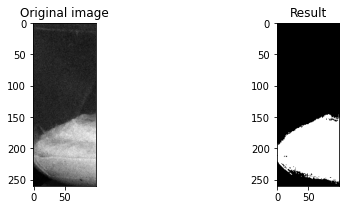

In [409]:
def to_binary_image(img, threshold):
    return img >= threshold

binary_image = to_binary_image(img, otsu_thresh)

fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
ax = axes.ravel()

ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(binary_image, cmap=plt.cm.gray)
ax[1].set_title('Result')

plt.show()

In [410]:
def image_regions(binary_image):
    label_img = label(binary_image)
    regions = regionprops(label_img)
    return regions

regions = image_regions(binary_image)

In [411]:
def find_dough_region(regions, dough_area_threshold):
    for props in regions:
        minr, minc, maxr, maxc = props.bbox
        area = (maxc-minc)*(maxr-minr)

        if area >= dough_area_threshold:
            return props

dough_area_threshold = 500
dough_object = find_dough_region(regions, dough_area_threshold)

def dough_height(dough_object):
    y1, x1, y2, x2 = dough_object.bbox
    return y2 - y1

print(dough_height(dough_object))

108


In [412]:
def analyse_image(photo_path, crop, area_threshold):
    photo = read_photo(photo_path)
    cropped = crop_photo(photo, crop[0:2], crop[2:4])
    threshold = find_threshold(cropped)
    binary_image = to_binary_image(cropped, threshold)
    regions = image_regions(binary_image)
    dough_region = find_dough_region(regions, area_threshold)
    height = dough_height(dough_region)

    return (photo, cropped, binary_image, dough_region, height)

#### Final output from the image

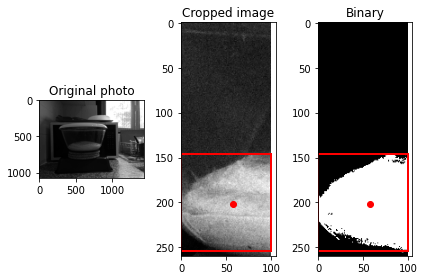

In [413]:
y1, x1, y2, x2 = dough_object.bbox

fig, axes = plt.subplots(1, 3)
ax = axes.ravel()

ax[0].imshow(photo, cmap='gray')
ax[0].set_title('Original photo')

rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, fill=0, color='red')
ax[1].imshow(img, cmap='gray')
ax[1].set_title('Cropped image')
ax[1].add_patch(rect)
ax[1].plot(dough_object.centroid[1], dough_object.centroid[0], 'or')

rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, fill=0, color='red')
ax[2].imshow(binary_image, cmap='gray')
ax[2].set_title('Binary')
ax[2].add_patch(rect)
ax[2].plot(dough_object.centroid[1], dough_object.centroid[0], 'or')

plt.tight_layout()
plt.show()

In [414]:
photos_directory = "../data/dough-photos/1"
output_directory = "../data/dough-photos/1-out"
cropped_coord = (450,710,400,500)
area_threshold = 500
time_interval = 5

times = []
heights = []

def extract_index(file):
    index = int(re.search('.*_.*_\((\d+)\)', file).group(1))
    return index

for file in sorted(os.listdir(photos_directory)):
    index = extract_index(file)
    (photo, cropped, binary_image, dough_region, height) = analyse_image(f'{photos_directory}/{file}', cropped_coord, area_threshold)

    times.append(index * time_interval)
    heights.append(height)

gif_imgs = []
for file in sorted(os.listdir(photos_directory)):
    index = extract_index(file)
    (photo, cropped, binary_image, dough_region, height) = analyse_image(f'{photos_directory}/{file}', cropped_coord, area_threshold)
    y1, x1, y2, x2 = dough_region.bbox

    fig3 = plt.figure(constrained_layout=True)
    gs = fig3.add_gridspec(2, 4)
    ax_photo = fig3.add_subplot(gs[0, :2])
    ax_cropped = fig3.add_subplot(gs[0, 2])
    ax_binary = fig3.add_subplot(gs[0, 3])
    ax_graph = fig3.add_subplot(gs[1, :])

    ax_photo.imshow(photo, cmap='gray')
    ax_photo.set_title('Original')
    ax_photo.set_xticklabels([])
    ax_photo.set_yticklabels([])
    rect = patches.Rectangle((cropped_coord[2], cropped_coord[0]), cropped_coord[3] - cropped_coord[2], cropped_coord[1] - cropped_coord[0], linewidth=1, edgecolor='r', facecolor='none')
    ax_photo.add_patch(rect)

    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1.5, fill=0, color='red')
    ax_cropped.imshow(cropped, cmap='gray')
    ax_cropped.set_title('Cropped')
    ax_cropped.add_patch(rect)
    ax_cropped.plot(dough_region.centroid[1], dough_region.centroid[0], 'or')
    ax_cropped.set_xticklabels([])
    ax_cropped.set_yticklabels([])

    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, fill=0, color='red')
    ax_binary.imshow(binary_image, cmap='gray')
    ax_binary.set_title('Binary')
    ax_binary.add_patch(rect)
    ax_binary.plot(dough_region.centroid[1], dough_region.centroid[0], 'or')
    ax_binary.set_xticklabels([])
    ax_binary.set_yticklabels([])

    ax_graph.set_title('Dough height in time')
    ax_graph.set_xlabel('minutes')
    ax_graph.set_ylabel('height')
    ax_graph.plot(times, heights)
    ax_graph.plot(index * time_interval, height, 'or')
    ax_graph.grid()

    plt.tight_layout()
    plt.savefig(f'{output_directory}/{index}.png', dpi=200)
    plt.close(fig3)
    gif_imgs.append(imageio.imread(f'{output_directory}/{index}.png'))

    print(f'Processed image #{index}')

imageio.mimsave(os.path.join(f'{output_directory}/movie.gif'), gif_imgs, duration = 0.1)

<ipython-input-414-9f02c5b63fc6>:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


Processed image #0
Processed image #1
Processed image #2
Processed image #3
Processed image #4
Processed image #5
Processed image #6
Processed image #7
Processed image #8
Processed image #9
Processed image #10
Processed image #11
Processed image #12
Processed image #13
Processed image #14
Processed image #15
Processed image #16
Processed image #17
Processed image #18
Processed image #19
Processed image #20
Processed image #21
Processed image #22
Processed image #23
Processed image #24
Processed image #25
Processed image #26
Processed image #27
Processed image #28
Processed image #29
Processed image #30
Processed image #31
Processed image #32
Processed image #33
Processed image #34
Processed image #35
Processed image #36
Processed image #37
Processed image #38
Processed image #39
Processed image #40
Processed image #41
Processed image #42
Processed image #43
Processed image #44
Processed image #45
Processed image #46
Processed image #47
Processed image #48
Processed image #49
Processed 